# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

This project is not supposed to take all your free time. Do not focus too much on tiny metrics improvement once you have an already working model. You will be judged on your coding skills, visualisations, vulgarisation and presentation. Good coding practices are strongly encouraged!
The presentation should be roughly 5-10 minutes. Imagine you are presenting your project to one of our clients, i.e. a mix between technical and non-technical audience.



## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!


## Deliverable

The end-goal is to deliver us:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a very brief presentation covering the following points:
    * Introduction to the problem (what are we trying to achieve and why) - max 1 slide
    * Libraries used - max 1 slide
    * Data Processing Pipeline - max 2 slides
    * Feature Engineering (if relevant) - max 1 slide
    * Modeling - max 1 slide
    * Results & Visualization - max 2 slides
* The goal of the presentation is to make it **understandable by a business person**, apart from how modeling techniques which do not have to be explained how they work.

# Libraries Loading

In [1]:
import os
from pathlib import Path
import shutil

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score,accuracy_score

# Data Preparation & Cleaning

In [4]:
#Create a directory "data_EmoDB" storing the data
#Call the path of this directory "datapath"
#Audio files are stored in the subdirectory "raw"
#CSV files are stored in the subdirectory "processed"
if not os.path.exists("./data_EmoDB"):
    os.mkdir("data_EmoDB")
datapath=os.path.join(Path().absolute(),"data_EmoDB")

#Create the subdirectory "./data_EmoDB/processed"
if not os.path.exists(os.path.join(datapath,"processed")):
    os.makedirs(os.path.join(datapath,"processed"))

#Copy the downloaded audio files from ./download/wav to ./data_EmoDB/raw
#Create the subdirectories "raw" and "processed"
path_source="./download/wav"
path_dest=os.path.join(datapath,"raw")
if not os.path.exists(path_dest):      
    if os.path.exists(path_source):
        #Create the subdirectory "raw"
        os.makedirs(path_dest)
        
        #iterate through all files in the directory and copy all .wav files
        for entry in os.scandir(path_source):
            filename=entry.path
            if filename.endswith("wav"):
                shutil.copy2(filename,path_dest)
        print("The audio files were successfully copied to %s."
              " The folder 'download' may now be deleted."%(path_dest))
        
    else:
        print("Error: The dataset was not found. Please download "
               "the complete dataset from \nhttp://emodb.bilderbar.info/index-1280.html"
              " and extract it to the directory this Jupyter Notebook is stored. "
             "\nEnsure that the folder is named 'download'.")
else:
    print("The audio files have already been copied.")
    

    

The audio files have already been copied.


# Feature Engineering & Modeling

In [11]:
def get_stats(matrix):
    """Returns the 0.05-quantile, the 0.2-quantile,..., and the 0.95-quantile.
        
        Outputs an one-dimensional array consisting of all numbers 
        'p-quantile(row i of matrix)', 
        where p is in {0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95}
        and i is in {1,..., number of rows of matrix}
    
    """
    output=np.array([])
    
    #Use quantiles because they result in better performance than other statistics 
    #(such as the mean, variance, skewness, kurtosis, max, min, range)
    quantiles=0.01*np.array(range(5,100,15))
    for p in quantiles:
        output=np.concatenate([output,np.quantile(matrix,p,axis=1)])
    return output

def is_valid_audio_file(file_path):
    valid_labels={"A","E","F","L","N","T","W"}
    return file_path.endswith(".wav") and len(file_path)>=6 and file_path[-6] in valid_labels

print("Extracting labels and features.")

X=[]  #"feature matrix"
y=[]  #"label vector"

#Scan all files in the directory "raw"
for file in os.scandir(os.path.join(datapath,"raw")):
    if is_valid_audio_file(file.path):        
        #Extract the label from the filename
        #"A"≙fear, "E"≙disgust, "F"≙joy, "L"≙boredom, "N"≙neutral, "T"≙sadness, "W"≙anger
        label=file.path[-6]
        
        #Extract the features
        #First, the whole audio file is (automatically) split into shorter time frames
        #Then, the MFCC and the energy are computed for each time frame
        #Finally, the quantiles (over time) are used as features
        #First-order and second-order MFCC are not used due to worse performance
        audio,sr=librosa.load(file.path,sr=None)
        #In the following matrix, the entry mfcc_(i,j) is the i-th coefficient of time frame j
        mfcc=librosa.feature.mfcc(audio,sr,n_mfcc=35) 
        energy=librosa.feature.rms(audio)        
        mfcc_stats=get_stats(mfcc) 
        energy_stats=get_stats(energy)
        
        #Append the features and the label
        features=np.concatenate([mfcc_stats,energy_stats])
        X.append(features)
        y.append(label)

#Split into training and test dataset
seed=42
X_train,X_test=train_test_split(X,train_size=0.8,random_state=seed)
y_train,y_test=train_test_split(y,train_size=0.8,random_state=seed)

#Standardize the features to have mean 0 and variance 1
X_train=StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)

#Save the files in "./data_EmoDB/processed/"
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.DataFrame(y_train,columns=["y"])
y_test=pd.DataFrame(y_test,columns=["y"])

X_train.to_csv(os.path.join(datapath,"processed","X_train.csv"),index=False)
X_test.to_csv(os.path.join(datapath,"processed","X_test.csv"),index=False)
y_train.to_csv(os.path.join(datapath,"processed","y_train.csv"),index=False)
y_test.to_csv(os.path.join(datapath,"processed","y_test.csv"),index=False)

print("Labels and features successfully extracted.")



Extracting labels and features.
Labels and features successfully extracted.


# Results & Visualizations

Balanced accuracy score using 10-fold CV (on the training set): 0.833
Balanced accuracy score using 5-times 10-fold CV (on the training set): 0.834
Balanced accuracy score on the test set: 0.861 



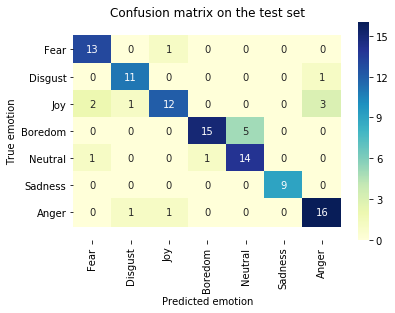



              precision    recall  f1-score   support

        Fear       0.81      0.93      0.87        14
     Disgust       0.85      0.92      0.88        12
         Joy       0.86      0.67      0.75        18
     Boredom       0.94      0.75      0.83        20
     Neutral       0.74      0.88      0.80        16
     Sadness       1.00      1.00      1.00         9
       Anger       0.80      0.89      0.84        18

    accuracy                           0.84       107
   macro avg       0.86      0.86      0.85       107
weighted avg       0.85      0.84      0.84       107



In [12]:
def n_times_cv_score(estimator,X,y,n_jobs=None,scoring=None,
                     n_splits=5,n_times=1,print_intermediate_results=False):
    """Returns an average cross validation score of a classifier.
        
        Performs 'n_splits'-fold cross validation 'n_times'-times 
        using the classifier 'estimator' and the scoring metric 'scoring' 
        and returns the mean cross validation score.
    
    """
    score=[]
    for i in range(1,n_times+1):
        kfold=StratifiedKFold(n_splits=n_splits,shuffle=True)
        sc=cross_val_score(estimator=estimator,X=X,y=y,
                           scoring=scoring,n_jobs=n_jobs,cv=kfold)
        score.append(sc.mean())
        if print_intermediate_results:
            print("%d-th Iteration: %.4f"%(i,np.mean(score)))
    return np.mean(score)




#Load training and test data
current_path=Path().absolute()
X_train=np.array(pd.read_csv(os.path.join(datapath,"processed","X_train.csv")))
X_test=np.array(pd.read_csv(os.path.join(datapath,"processed","X_test.csv")))
y_train=pd.read_csv(os.path.join(datapath,"processed","y_train.csv")).values.ravel()
y_test=pd.read_csv(os.path.join(datapath,"processed","y_test.csv")).values.ravel()

#Define the classifier
clf=SVC(C=5000,gamma=0.0016,class_weight="balanced")

#Perform cross-validation on the training set
n_splits=10 #number of folds
#Use the metric "balanced accuracy score" due to (slight) class imbalance
kfold=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=None)
score_cv=cross_val_score(clf,X_train,y_train,
                         scoring="balanced_accuracy",cv=kfold,n_jobs=-1)
print("Balanced accuracy score using %d-fold CV (on the training set): %.3f"%(n_splits,score_cv.mean()))

n_times=5 #How often cross validation is performed
score_n_times_cv=n_times_cv_score(clf,X_train,y_train,n_jobs=8,
                                  scoring="balanced_accuracy",
                                  n_splits=n_splits,n_times=n_times)
print("Balanced accuracy score using %d-times %d-fold CV (on the training set): %.3f"
      %(n_times, n_splits,score_n_times_cv))

#Compute the prediction accuracy on the test set
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
score_test=balanced_accuracy_score(y_test,y_pred)
print("Balanced accuracy score on the test set: %.3f \n"%(score_test.mean()))

#Print the confusion matrix
confusion_matrix=sklearn.metrics.confusion_matrix(y_test,y_pred)
#Arrange all labels/emotions in an alphabetical order (the Labels are in German)
#because sklearn orders the labels in an alphabetical order
target_names=["Fear","Disgust","Joy","Boredom","Neutral","Sadness","Anger"] 
confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                   index=target_names, columns=target_names)

heatmap=sns.heatmap(confusion_matrix_df, annot=True,cmap="YlGnBu") 
heatmap.set_title("Confusion matrix on the test set")
heatmap.set_ylabel("True emotion")
heatmap.set_xlabel("Predicted emotion")
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5) #Workaround for a bug in matplotlib
plt.show()
print("\n")

#Print a classification report
print(sklearn.metrics.classification_report(y_test,y_pred,target_names=target_names))